In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set Seed for Reproducibility (So your random numbers are the same as mine)
np.random.seed(42)

# 2. Define the "Physics" Functions

def geometric_adstock(spend_data, decay_rate):
    """
    The 'Echo' Effect.
    decay_rate: 0.0 to 1.0
    - 0.8 means 80% of the ad effect carries over to the next week (Long Memory).
    - 0.1 means only 10% carries over (Short Memory).
    """
    adstocked_spend = np.zeros(len(spend_data))
    carryover = 0  # Initial memory is zero
    
    for t in range(len(spend_data)):
        # Today's effect = Today's Spend + (Yesterday's Memory * Decay)
        adstocked_spend[t] = spend_data[t] + (carryover * decay_rate)
        carryover = adstocked_spend[t] # Update memory for next loop
        
    return adstocked_spend

def hill_saturation(spend_data, alpha, beta):
    """
    The 'Sponge' Effect (Diminishing Returns).
    - alpha (Half-Saturation Point): The spend amount where you get 50% of max impact.
    - beta (Shape): How steep the curve is.
    """
    # Formula: 1 / (1 + (Spend / Alpha)^(-Beta))
    return 1 / (1 + (spend_data / alpha)**(-beta))

In [3]:
# 3. Create Timeline (Weekly Data for 3 Years)
# 156 Weeks = 3 Years
dates = pd.date_range(start='2021-01-01', periods=156, freq='W-MON')

# 4. Simulate Raw Ad Spend (Dollars)
# We use random numbers, but scale them to look like real budgets.
tv_spend = np.random.gamma(shape=2, scale=2000, size=len(dates))     # High volatility
social_spend = np.random.gamma(shape=4, scale=1000, size=len(dates)) # Consistent
radio_spend = np.random.gamma(shape=1, scale=500, size=len(dates))   # Low budget

# Put it in a DataFrame
df = pd.DataFrame({
    'Date': dates,
    'TV_Spend': tv_spend,
    'Social_Spend': social_spend,
    'Radio_Spend': radio_spend
})

print("Raw Spends Generated. First 5 rows:")
print(df.head())

Raw Spends Generated. First 5 rows:
        Date     TV_Spend  Social_Spend  Radio_Spend
0 2021-01-04  4787.358780   5358.987888   380.273624
1 2021-01-11  2988.929460    303.414810    26.607326
2 2021-01-18  2764.567169   2034.111818   205.191801
3 2021-01-25  2764.604589   7764.889330    72.174663
4 2021-02-01  9299.428824   1553.345863    32.736129


In [4]:
# 5. Apply the "Physics" to calculate EFFECTIVE Spend
# (This is what actually drives sales, not the raw dollars)

# TV: Long Memory (0.8), Saturates at $10k
tv_effective = hill_saturation(geometric_adstock(df['TV_Spend'], decay_rate=0.8), alpha=10000, beta=1.5)

# Social: Short Memory (0.3), Saturates at $5k
social_effective = hill_saturation(geometric_adstock(df['Social_Spend'], decay_rate=0.3), alpha=5000, beta=1.5)

# Radio: Medium Memory (0.5), Saturates at $2k
radio_effective = hill_saturation(geometric_adstock(df['Radio_Spend'], decay_rate=0.5), alpha=2000, beta=1.5)


# 6. Create Seasonality (The Natural Ups and Downs)
# A sine wave that peaks in December (Week 52)
week_of_year = df['Date'].dt.isocalendar().week
seasonality = 5000 * np.sin(2 * np.pi * week_of_year / 52)


# 7. Calculate TOTAL SALES
# Formula: Base Sales + (Coefficient * Effective Spend) + Seasonality + Noise

base_sales = 10000 # We sell $10k even with zero ads

# "True" Coefficients (The multipliers we want our model to find later!)
coef_tv = 30000
coef_social = 25000
coef_radio = 15000

# Add it all up
noise = np.random.normal(0, 2000, len(dates)) # Random daily variance

df['Sales'] = base_sales + \
              (coef_tv * tv_effective) + \
              (coef_social * social_effective) + \
              (coef_radio * radio_effective) + \
              seasonality + \
              noise

# Round to 2 decimal places for realism
df = df.round(2)

✅ Data Saved to data/raw/mmm_synthetic_data.csv


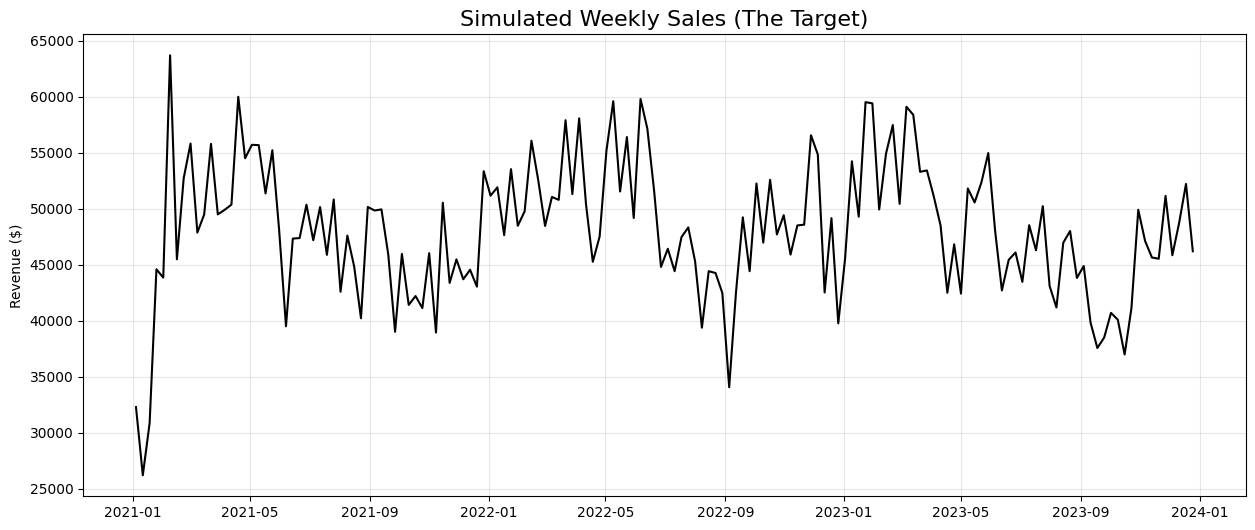

In [ ]:
# 8. Save the "Real World" View
# We hide the 'Effective' columns because the model needs to learn those itself!
final_df = df[['Date', 'TV_Spend', 'Social_Spend', 'Radio_Spend', 'Sales']]

# Save to CSV
# Make sure the 'data/raw' folder exists first!
import os
os.makedirs('../data/raw', exist_ok=True) # Create folder if not exists
final_df.to_csv('../data/raw/mmm_synthetic_data.csv', index=False)

print("Data Saved to data/raw/mmm_synthetic_data.csv")

# 9. Quick Visualization
plt.figure(figsize=(15, 6))
plt.plot(final_df['Date'], final_df['Sales'], label='Sales', color='black', linewidth=1.5)
plt.title("Simulated Weekly Sales (The Target)", fontsize=16)
plt.ylabel("Revenue ($)")
plt.grid(True, alpha=0.3)
plt.show()